In [ ]:
!pip list # lists all installed libraries

In [1]:
#### Import necessary libraries ####

# Machine Learning library 
import tensorflow as tf 
# Library for OS commands such as delete files
import os 
# Check file extensions of images
import imghdr 
# You know it from the lecture
import cv2 
import numpy as np 
from matplotlib import pyplot as plt

# Deep Learning
# Sequential API --> 1 input, 1 output; there's a Functional API too for more complex tasks
from tensorflow.keras.models import Sequential 
# Layer import: 
# Conv2D --> Convolutional layer
# MaxPooling2D --> Condensing layer 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

# Visualize model 
import visualkeras
from PIL import ImageFont


# Evaluation and testing 
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
# For saving the model
from tensorflow.keras.models import load_model 


# Notes
# This coding example is based on "Build a Deep CNN Image Classifier with ANY Images" 
# by Nicholas Renotte (https://www.youtube.com/watch?v=jztwpsIzEGc). This notebook contains comments 
# and modifications. It is used for a presentation on "Maschinelle Wahrnehmung" (Machine Perception)
# held by Annika Scherer on 27. May 2023. The topic of the presentation is "Klassifizierung mittels eines tiefen
# neuronalen Netzes" (Classification with a deep neural network).

In [ ]:
# Avoid Out of Memory Error by setting GPU memory consumption growth 
# gpus = tf.config.experimental.list_physical_devices('GPU')

# len(gpus)
# for gpu in gpus: 
#     tf.config.experimental.set_memory_growth(gpu, True)


In [2]:
# Clean up data downloaded from web 
data_dir = 'data' 
image_exts = ['jpeg','jpg', 'bmp', 'png']
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)
    


In [ ]:
# Query for help in Jupyter Notebook
tf.data.Dataset??

In [3]:
# Load trainingsdata, builds image dataset, preprocessing 
# --> builds labels and classes; creates consistent size (resize images) and batches them up
# query the help topic as shown in above help to configure the command
data = tf.keras.utils.image_dataset_from_directory('data') 
data

Found 948 files belonging to 2 classes.


<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
# query for help in Jupyter Notebook
tf.keras.utils.image_dataset_from_directory??
# --> run to see the how the images are configured 

In [4]:
# Allow us to create batches of data, iterates through data pipeline
data_iterator = data.as_numpy_iterator()

In [5]:
# Access data pipeline itself, grabbing a batch of data 
# Run again to get another batch from the iterator
batch = data_iterator.next()
len(batch) # tuple: image representation as numpy array, label

2

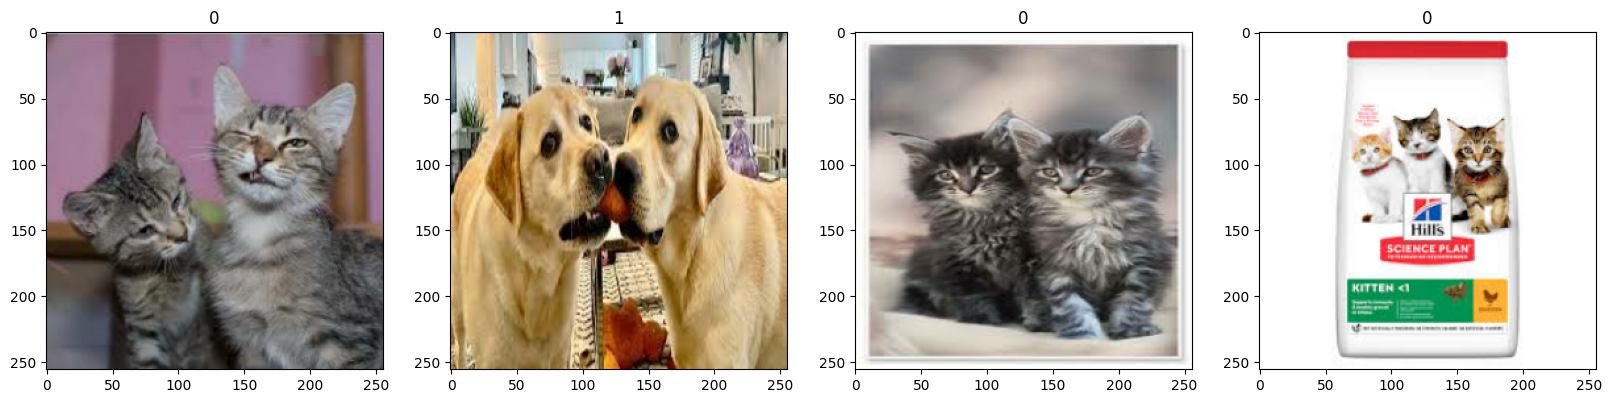

In [6]:
# visualization 
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])
    
# Note
# We have two folders, the first contains kittens, the second contains puppies. 
# Based on this we were able to label the data that we collected from the Google picture search. 
# class 0 --> kitten 
# class 1 --> puppy 

In [7]:
# Scale data --> Why?
# https://analyticsindiamag.com/why-data-scaling-is-important-in-machine-learning-how-to-effectively-do-it/
# Chances are better to train the model better and faster
# --> Accuracy is higher when the difference between the data values is lower
# Modify the dataset so the image representations are values between 0.0 and 1.0 
data = data.map(lambda x,y: (x/255, y)) 

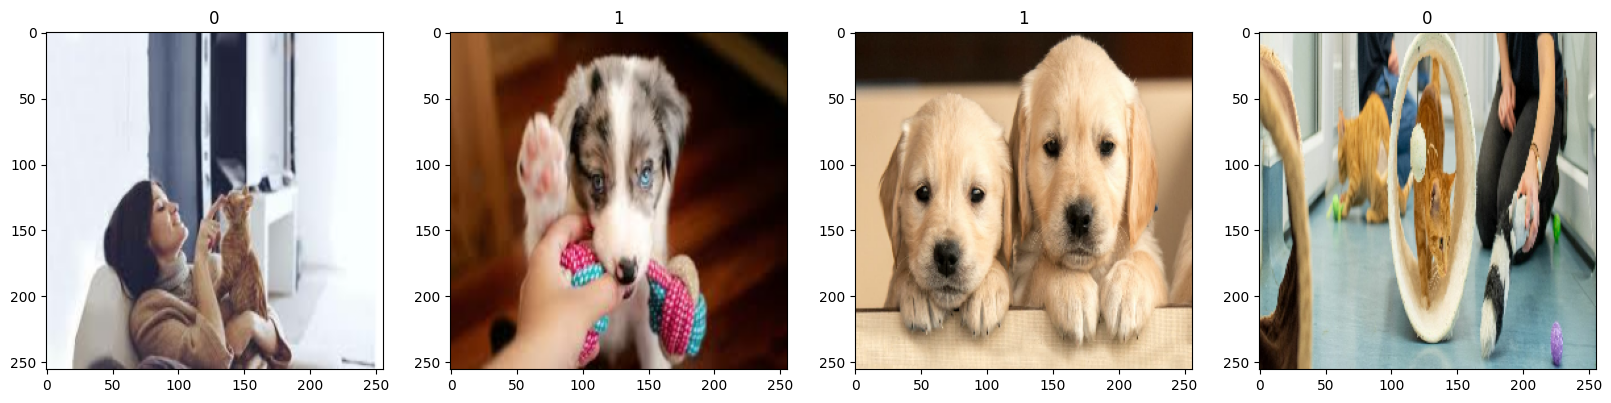

In [8]:
# Grab next batch
scaled_iterator = data.as_numpy_iterator()
batch = scaled_iterator.next()
#batch[0].min()

# Visualization 
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img) # do not convert to int here because our values are between 0.0 and 1.0
    ax[idx].title.set_text(batch[1][idx])

In [9]:
# Partitioning the data set 
len(data) 

30

In [11]:
train_size = int(len(data)*0.7) # training set = 70 % of our data --> data partition that is used for training the model
val_size = int(len(data)*0.2) # validation set = 20 % of our data --> data used to evaluate model while training
test_size = int(len(data)*0.1) # ONLY used at the end! --> post training

print("Train size: {0}\nVal size: {1}\nTest size: {2}\n".format(train_size, val_size, test_size))
print("Sum of partitions: {0}\nPartitions of dataset: {1}".format(train_size+val_size+test_size, len(data)))

Train size: 21
Val size: 6
Test size: 3

Sum of partitions: 30
Partitions of dataset: 30


In [12]:
# Allocate partitions with TensorFlow
# Take specified amount of batches out of our data pipeline
train = data.take(train_size) 
# Skip the training data and take the next batches
val = data.skip(train_size).take(val_size) 
# Skip training and validation data and take the last batch(es)
test = data.skip(train_size+val_size).take(test_size) 

print("Train: {0}\nVal: {1}\nTest: {2}\n".format(len(train), len(val), len(test)))

Train: 21
Val: 6
Test: 3



In [13]:
# Deep Learning starts here --> create instance of Sequential class
model = Sequential()

In [14]:
# Chain the layers, create architecture of the model
# Input layer: Convolutional with 16 filters, extract relevant information inside an image to make an output classification
# Number of filters: 16; Filter size: 3x3; Stepsize: 1 pixel
# ReLU activation function: negative values equal zero, positive remain unchanged
# Input shape = default shape of our tf.keras.utils.image_dataset_from_directory function --> width, height equal 256, 3 channels 
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
# Condense/compress information down
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
# Output Layer: 1 Output value that is either 1 or 0 --> sigmoid activation
model.add(Dense(1, activation='sigmoid'))

In [15]:
# Gradient descent: Adam; Binary loss --> kitten or puppy; Accuracy: evaluate how well our model is classifying
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy']) 

In [16]:
# Summary 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

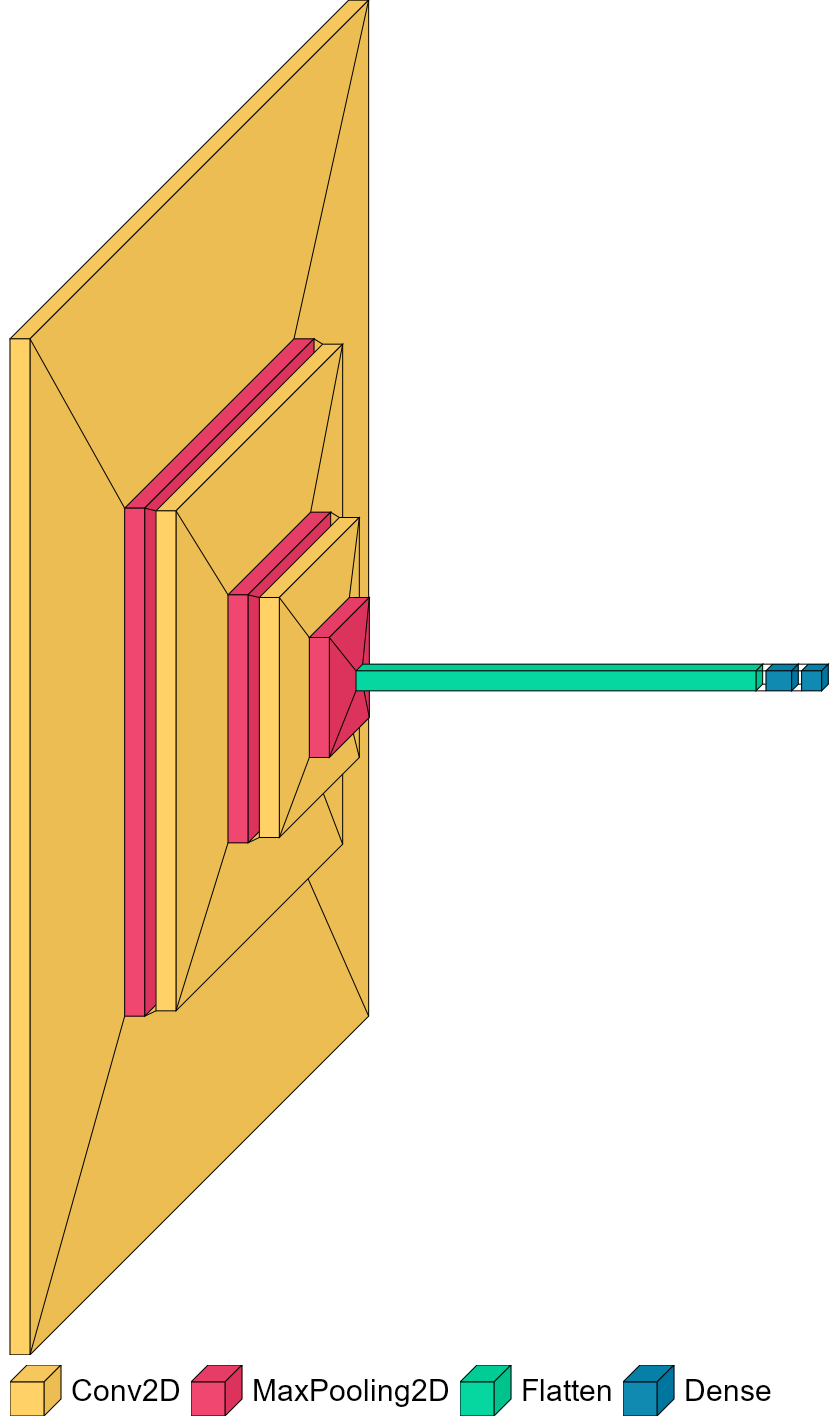

In [17]:
# Visualize the model
# https://analyticsindiamag.com/how-to-visualize-deep-learning-models-using-visualkeras/
font = ImageFont.truetype("arial.ttf", 30)
visualkeras.layered_view(model, legend=True, font=font)

In [18]:
# Point to logs directory 
logdir="logs"

In [19]:
# Set log
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [20]:
# The actual training happens here
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

# Goal: decrease loss, increase accuracy 

Epoch 1/20
21/21 [==============================] - 33s 1s/step - loss: 0.8681 - accuracy: 0.5179 - val_loss: 0.6876 - val_accuracy: 0.6302
Epoch 2/20
21/21 [==============================] - 31s 1s/step - loss: 0.6912 - accuracy: 0.5372 - val_loss: 0.6867 - val_accuracy: 0.6458
Epoch 3/20
21/21 [==============================] - 31s 1s/step - loss: 0.6400 - accuracy: 0.6771 - val_loss: 0.9535 - val_accuracy: 0.5000
Epoch 4/20
21/21 [==============================] - 31s 1s/step - loss: 0.5746 - accuracy: 0.7277 - val_loss: 0.5881 - val_accuracy: 0.6302
Epoch 5/20
21/21 [==============================] - 31s 1s/step - loss: 0.4758 - accuracy: 0.8065 - val_loss: 0.5173 - val_accuracy: 0.7552
Epoch 6/20
21/21 [==============================] - 32s 1s/step - loss: 0.4011 - accuracy: 0.8333 - val_loss: 0.4615 - val_accuracy: 0.7812
Epoch 7/20
21/21 [==============================] - 31s 1s/step - loss: 0.2802 - accuracy: 0.9003 - val_loss: 0.4234 - val_accuracy: 0.8021
Epoch 8/20
21/21 [==

In [ ]:
# output the data in hist --> delivers values for each epoch 
hist.history

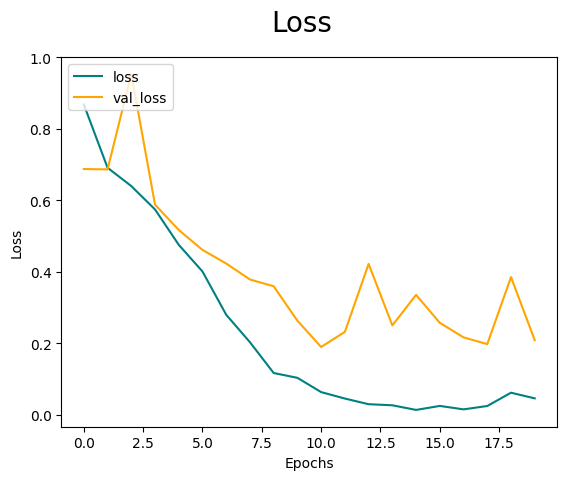

In [21]:
# Plot information from training
# Loss: decreases over time, validation loss looks good too, if it would increase again over time --> sign for overfitting
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="upper left")
plt.show()

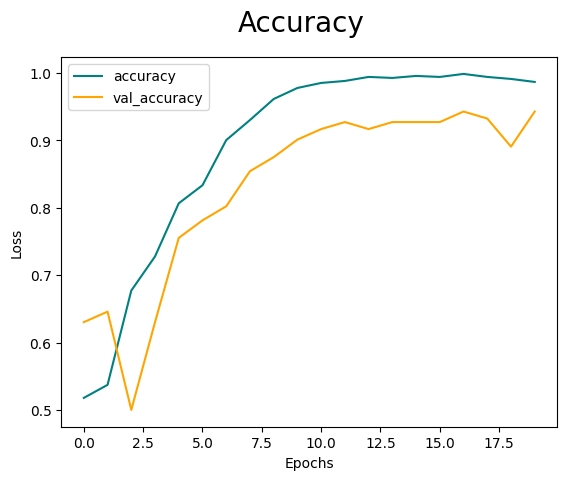

In [22]:
# Accuracy: increases over time --> good sign
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="upper left")
plt.show()

In [23]:
# Evaluation of Performance
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

len(test)

3

In [24]:
for batch in test.as_numpy_iterator(): # runs once
    X, y = batch # X: set of images, y: label
    yhat = model.predict(X) # model predicts a label for the image
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)
    
print("Precision: {0}\nRecall: {1}\nAccuracy: {2}".format(pre.result().numpy(), re.result().numpy(), acc.result().numpy()))

1/1 [==============================] - 0s 309ms/step
Precision: 0.9743589758872986
Recall: 0.949999988079071
Accuracy: 0.9642857313156128


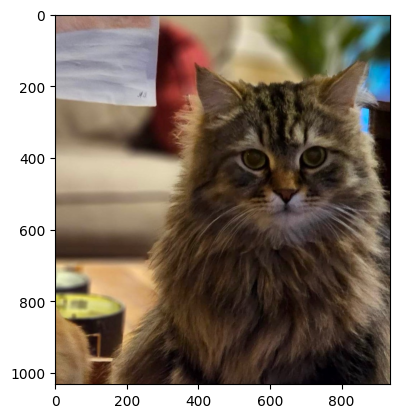

In [65]:
# Test the model
# img = cv2.imread('_penny.jpg')
img = cv2.imread('_chouchou.jpg')
# img = cv2.imread('_ponpon.jpg')
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
plt.imshow(img)
plt.show()

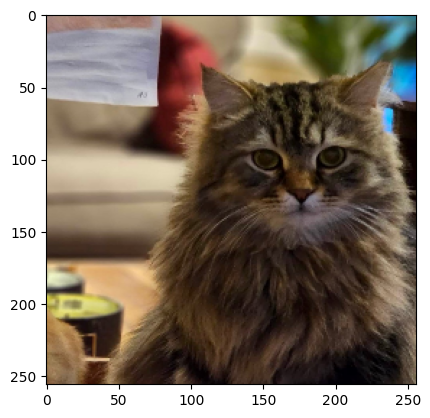

In [66]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [56]:
# Predict the image from above, expand array dimension and scale
yhat = model.predict(np.expand_dims(resize/255, 0))
print(yhat[0])

# Set threshold
if yhat > 0.5: 
    print("Predicted class: Puppy")
else:
    print("Predicted class: Kitten")

1/1 [==============================] - 0s 73ms/step
[0.5826274]
Predicted class: Puppy


In [57]:
# Saving the model
model.save(os.path.join('models','puppy_kitten_classifier.h5'))

In [58]:
new_model = load_model(os.path.join('models', 'puppy_kitten_classifier.h5'))

In [67]:
yhat_new = new_model.predict(np.expand_dims(resize/255, 0))
print(yhat_new[0])
# Set threshold
if yhat_new > 0.5: 
    print("Predicted class: Puppy")
else:
    print("Predicted class: Kitten")

1/1 [==============================] - 0s 66ms/step
[0.01419423]
Predicted class: Kitten
